# Tutorial 2 Thinking with Deep Learning: Week 8 Part 2
# Deep Reinforcement Learning 

__Instructor:__ James Evans

__Notebook Author:__ Bhargav Srinivasa Desikan

__Teaching Assistants & Course Organizers:__ Likun Cao & Partha Kadambi 


In this notebook we will continue from our basic reinforcement learning onto deep reinforcement learning.

# Actor Critic Method

We will be drawing heavily on the [Keras documentation tutorial](https://keras.io/examples/rl/actor_critic_cartpole/) by [Apoorv Nandan](https://twitter.com/NandanApoorv). As noted in the last notebook, the Actor Critic approach merges policy gradient learning with value learning, but here using modern libraries that improve the automatic differentiation required for RL at scale.

## Introduction

This script shows an implementation of Actor Critic method on the now *very familiar* CartPole-V0 environment.

### Actor Critic Method

As an agent takes actions and moves through an environment, it learns to map
the observed state of the environment to two possible outputs:

1. Recommended action: A probability value for each action in the action space.
   The part of the agent responsible for this output is called the **actor**.
2. Estimated rewards in the future: Sum of all rewards it expects to receive in the
   future. The part of the agent responsible for this output is the **critic**.

Agent and Critic learn to perform their tasks, such that the recommended actions
from the actor maximize the rewards.

### CartPole-V0

A pole is attached to a cart placed on a frictionless track. The agent has to apply
force to move the cart. It is rewarded for every time step the pole
remains upright. The agent, therefore, must learn to keep the pole from falling over.

### References

- [CartPole](http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf)
- [Actor Critic Method](https://hal.inria.fr/hal-00840470/document)


## Setup


In [1]:
!pip install pygame

     |████████████████████████████████| 21.8 MB 81.2 MB/s 


In [2]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Configuration parameters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
max_steps_per_episode = 10000
env = gym.make("CartPole-v0")  # Create the environment
env.seed(seed)
eps = np.finfo(np.float32).eps.item()  # Smallest number such that 1.0 + eps != 1.0


## Implement Actor Critic network

This network learns two functions:

1. Actor: This takes as input the state of our environment and returns a
probability value for each action in its action space.
2. Critic: This takes as input the state of our environment and returns
an estimate of total rewards in future.

In our implementation, they share the initial layer.


In [3]:
num_inputs = 4
num_actions = 2
num_hidden = 128

inputs = layers.Input(shape=(num_inputs,))
common = layers.Dense(num_hidden, activation="relu")(inputs)
action = layers.Dense(num_actions, activation="softmax")(common)
critic = layers.Dense(1)(common)

model = keras.Model(inputs=inputs, outputs=[action, critic])


## Train


In [4]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
huber_loss = keras.losses.Huber()
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0

while True:  # Run until solved
    state = env.reset()
    episode_reward = 0
    with tf.GradientTape() as tape:
        for timestep in range(1, max_steps_per_episode):
            # env.render(); Adding this line would show the attempts
            # of the agent in a pop up window.

            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)

            # Predict action probabilities and estimated future rewards
            # from environment state
            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0, 0])

            # Sample action from action probability distribution
            action = np.random.choice(num_actions, p=np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            # Apply the sampled action in our environment
            state, reward, done, _ = env.step(action)
            rewards_history.append(reward)
            episode_reward += reward

            if done:
                break

        # Update running reward to check condition for solving
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

        # Calculate expected value from rewards
        # - At each timestep what was the total reward received after that timestep
        # - Rewards in the past are discounted by multiplying them with gamma
        # - These are the labels for our critic
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        # Normalize
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
        returns = returns.tolist()

        # Calculating loss values to update our network
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            # At this point in history, the critic estimated that we would get a
            # total reward = `value` in the future. We took an action with log probability
            # of `log_prob` and ended up recieving a total reward = `ret`.
            # The actor must be updated so that it predicts an action that leads to
            # high rewards (compared to critic's estimate) with high probability.
            diff = ret - value
            actor_losses.append(-log_prob * diff)  # actor loss

            # The critic must be updated so that it predicts a better estimate of
            # the future rewards.
            critic_losses.append(
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Clear the loss and reward history
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

    # Log details
    episode_count += 1
    if episode_count % 10 == 0:
        template = "running reward: {:.2f} at episode {}"
        print(template.format(running_reward, episode_count))

    if running_reward > 195:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break


running reward: 10.35 at episode 10
running reward: 22.61 at episode 20
running reward: 49.69 at episode 30
running reward: 82.33 at episode 40
running reward: 97.73 at episode 50
running reward: 101.74 at episode 60
running reward: 110.24 at episode 70
running reward: 125.27 at episode 80
running reward: 147.37 at episode 90
running reward: 126.59 at episode 100
running reward: 92.89 at episode 110
running reward: 101.03 at episode 120
running reward: 139.94 at episode 130
running reward: 156.66 at episode 140
running reward: 142.84 at episode 150
running reward: 153.20 at episode 160
running reward: 171.98 at episode 170
running reward: 183.22 at episode 180
running reward: 189.95 at episode 190
running reward: 193.99 at episode 200
Solved at episode 204!


## Visualizations
In early stages of training:
![Imgur](https://i.imgur.com/5gCs5kH.gif)

In later stages of training:
![Imgur](https://i.imgur.com/5ziiZUD.gif)


# Deep Q-Learning

The paper that started it all: [Human-level control through deep reinforcement learning](https://www.nature.com/articles/nature14236)

We will be starting the [Keras tutorial](https://keras.io/examples/rl/deep_q_network_breakout/) by [Jacob Chapman](https://twitter.com/jacoblchapman) and [Mathias Lechner](https://twitter.com/MLech20).

## Deep Q-Learning for Atari Breakout



## Introduction

This script shows an implementation of Deep Q-Learning on the
`BreakoutNoFrameskip-v4` environment.

### Deep Q-Learning

As detailed in the last homework, an agent takes actions and moves through an environment, learning to map
the observed state of the environment to an action. An agent will choose an action
in a given state based on a "Q-value", which is a weighted reward based on the
expected highest long-term reward. A Q-Learning Agent learns to perform its
task such that the recommended action maximizes the potential future rewards.
This method is considered an "Off-Policy" method,
meaning its Q values are updated assuming that the best action was chosen, even
if the best action was not chosen.

### Atari Breakout

In this environment, a board moves along the bottom of the screen returning a ball that
will destroy blocks at the top of the screen.
The aim of the game is to remove all blocks and breakout of the
level. The agent must learn to control the board by moving left and right, returning the
ball and removing all the blocks without the ball passing the board.

### Note

The Deepmind paper trained for "a total of 50 million frames (that is, around 38 days of
game experience in total)". However this script will give good results at around 10
million frames which are processed in less than 24 hours on a modern machine.

### References

- [Q-Learning](https://link.springer.com/content/pdf/10.1007/BF00992698.pdf)
- [Deep Q-Learning](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning)

## Setup

In [1]:
!git clone https://github.com/openai/baselines.git
import os
os.chdir('/content/baselines')
!pip install -e .

#after running this installation, restart the kernel.

fatal: destination path 'baselines' already exists and is not an empty directory.
Obtaining file:///content/baselines
  Attempting uninstall: baselines
    Found existing installation: baselines 0.1.6
    Can't uninstall 'baselines'. No files were found to uninstall.
  Running setup.py develop for baselines


In [10]:
#before running this block, create a new folder /content/Roms
!pip install patool
import patoolib
patoolib.extract_archive("/content/Roms.rar", outdir="/content/Roms")

patool: Extracting /content/Roms.rar ...
patool: running /usr/bin/unrar x -- /content/Roms.rar
patool:     with cwd='/content/Roms'
patool: ... /content/Roms.rar extracted to `/content/Roms'.


'/content/Roms'

In [11]:
!python -m atari_py.import_roms /content/Roms/

copying adventure.bin from HC ROMS/BY ALPHABET (PAL)/A-G/Adventure (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from HC ROMS/BY ALPHABET (PAL)/A-G/Air Raid (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Alien.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/alien.bin
copying crazy_climber.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Crazy Climber.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/crazy_climber.bin
copying elevator_action.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Elevator Action (Prototype).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/elevator_action.bin
copying gravitar.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Gravitar.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_

In [12]:
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Configuration paramaters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 10000

# Use the Baseline Atari environment because of Deepmind helper functions
env = make_atari("BreakoutNoFrameskip-v4")
# Warp the frames, grey scale, stake four frame and scale to smaller ratio
env = wrap_deepmind(env, frame_stack=True, scale=True)
env.seed(seed)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[42, 742738649]

## Implement the Deep Q-Network

This network learns an approximation of the Q-table, which is a mapping between
the states and actions that an agent will take. For every state we'll have four
actions, that can be taken. The environment provides the state, and the action
is chosen by selecting the larger of the four Q-values predicted in the output layer.

In [13]:
num_actions = 4


def create_q_model():
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(84, 84, 4,))

    # Convolutions on the frames on the screen
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)


# The first model makes the predictions for Q-values which are used to
# make a action.
model = create_q_model()
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = create_q_model()


## Train

In [14]:
# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 50000
# Number of frames for exploration
epsilon_greedy_frames = 1000000.0
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 100000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 10000
# Using huber loss for stability
loss_function = keras.losses.Huber()

while True:  # Run until solved
    state = np.array(env.reset())
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        # env.render(); Adding this line would show the attempts
        # of the agent in a pop up window.
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if running_reward > 40:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

running reward: 0.43 at episode 271, frame count 10000


KeyboardInterrupt: ignored

## Visualizations
Before any training:
![Imgur](https://i.imgur.com/rRxXF4H.gif)

In early stages of training:
![Imgur](https://i.imgur.com/X8ghdpL.gif)

In later stages of training:
![Imgur](https://i.imgur.com/Z1K6qBQ.gif)

## Other resources

We also highly recommend this tutorial from module 12 of the [Deep Learning](https://sites.wustl.edu/jeffheaton/t81-558/) course at  [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx), by  [Jeff Heaton](https://sites.wustl.edu/jeffheaton/):

- [Keras reinforce Deep Q-Learning](https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_03_keras_reinforce.ipynb)

# Double Deep Q Networks

Recall our discussion of Double Q-Learning in the last tutorial: using two Q tables to avoid the problematic feedback that result from making a bad decision with one.

The paper: [Deep Reinforcement Learning with Double Q-learning](https://arxiv.org/pdf/1509.06461.pdf)

We will be following the [PyTorch documentation tutorial](https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html) by [Yuansong Feng](https://github.com/YuansongFeng), [Suraj Subramanian](https://github.com/suraj813),  [Howard Wang](https://github.com/hw26) and [Steven Guo](https://github.com/GuoYuzhang).



## Train a Mario-playing RL Agent



In [1]:
!pip install nes_py
!pip install gym_super_mario_bros

     |████████████████████████████████| 76 kB 4.4 MB/s 
  Created wheel for nes-py: filename=nes_py-8.1.8-cp37-cp37m-linux_x86_64.whl size=441068 sha256=174af7ef5d39ea0812e23fd864434b29078ff995723f165ee718d40d4d3e4ef9
  Stored in directory: /root/.cache/pip/wheels/f2/05/1f/608f15ab43187096eb5f3087506419c2d9772e97000f3ba025
Successfully built nes-py
     |████████████████████████████████| 198 kB 14.3 MB/s 


In [2]:
# !pip install gym-super-mario-bros==7.3.0

import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os, copy

# Gym is an OpenAI toolkit for RL
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

# NES Emulator for OpenAI Gym
from nes_py.wrappers import JoypadSpace

# Super Mario environment for OpenAI Gym
import gym_super_mario_bros

RL Definitions
""""""""""""""""""

**Environment** The world that an agent interacts with and learns from.

**Action** $a$ : How the Agent responds to the Environment. The
set of all possible Actions is called *action-space*.

**State** $s$ : The current characteristic of the Environment. The
set of all possible States the Environment can be in is called
*state-space*.

**Reward** $r$ : Reward is the key feedback from Environment to
Agent. It is what drives the Agent to learn and to change its future
action. An aggregation of rewards over multiple time steps is called
**Return**.

**Optimal Action-Value function** $Q^*(s,a)$ : Gives the expected
return if you start in state $s$, take an arbitrary action
$a$, and then for each future time step take the action that
maximizes returns. $Q$ can be said to stand for the “quality” of
the action in a state. We try to approximate this function.




### Environment

### Initialize Environment
------------------------

In Mario, the environment consists of tubes, mushrooms and other
components.

When Mario makes an action, the environment responds with the changed
(next) state, reward and other info.




In [3]:
# Initialize Super Mario environment
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")

# Limit the action-space to
#   0. walk right
#   1. jump right
env = JoypadSpace(env, [["right"], ["right", "A"]])

env.reset()
next_state, reward, done, info = env.step(action=0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

(240, 256, 3),
 0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 79}


### Preprocess Environment

Environment data is returned to the agent in ``next_state``. As you saw
above, each state is represented by a ``[3, 240, 256]`` size array.
Often that is more information than our agent needs; for instance,
Mario’s actions do not depend on the color of the pipes or the sky!

We use **Wrappers** to preprocess environment data before sending it to
the agent.

``GrayScaleObservation`` is a common wrapper to transform an RGB image
to grayscale; doing so reduces the size of the state representation
without losing useful information. Now the size of each state:
``[1, 240, 256]``

``ResizeObservation`` downsamples each observation into a square image.
New size: ``[1, 84, 84]``

``SkipFrame`` is a custom wrapper that inherits from ``gym.Wrapper`` and
implements the ``step()`` function. Because consecutive frames don’t
vary much, we can skip n-intermediate frames without losing much
information. The n-th frame aggregates rewards accumulated over each
skipped frame.

``FrameStack`` is a wrapper that allows us to squash consecutive frames
of the environment into a single observation point to feed to our
learning model. This way, we can identify if Mario was landing or
jumping based on the direction of his movement in the previous several
frames.




In [4]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)

After applying the above wrappers to the environment, the final wrapped
state consists of 4 gray-scaled consecutive frames stacked together, as
shown above in the image on the left. Each time Mario makes an action,
the environment responds with a state of this structure. The structure
is represented by a 3-D array of size ``[4, 84, 84]``.

.. figure:: /_static/img/mario_env.png
   :alt: picture





### Agent


We create a class ``Mario`` to represent our agent in the game. Mario
should be able to:

-  **Act** according to the optimal action policy based on the current
   state (of the environment).

-  **Remember** experiences. Experience = (current state, current
   action, reward, next state). Mario *caches* and later *recalls* his
   experiences to update his action policy.

-  **Learn** a better action policy over time




In [5]:
class Mario:
    def __init__():
        pass

    def act(self, state):
        """Given a state, choose an epsilon-greedy action"""
        pass

    def cache(self, experience):
        """Add the experience to memory"""
        pass

    def recall(self):
        """Sample experiences from memory"""
        pass

    def learn(self):
        """Update online action value (Q) function with a batch of experiences"""
        pass

In the following sections, we will populate Mario’s parameters and
define his functions.




### Act

For any given state, an agent can choose to do the most optimal action
(**exploit**) or a random action (**explore**).

Mario randomly explores with a chance of ``self.exploration_rate``; when
he chooses to exploit, he relies on ``MarioNet`` (implemented in
``Learn`` section) to provide the optimal action.




In [6]:
class Mario:
    def __init__(self, state_dim, action_dim, save_dir):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir

        self.use_cuda = torch.cuda.is_available()

        # Mario's DNN to predict the most optimal action - we implement this in the Learn section
        self.net = MarioNet(self.state_dim, self.action_dim).float()
        if self.use_cuda:
            self.net = self.net.to(device="cuda")

        self.exploration_rate = 1
        self.exploration_rate_decay = 0.99999975
        self.exploration_rate_min = 0.1
        self.curr_step = 0

        self.save_every = 5e5  # no. of experiences between saving Mario Net

    def act(self, state):
        """
    Given a state, choose an epsilon-greedy action and update value of step.

    Inputs:
    state(LazyFrame): A single observation of the current state, dimension is (state_dim)
    Outputs:
    action_idx (int): An integer representing which action Mario will perform
    """
        # EXPLORE
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)

        # EXPLOIT
        else:
            state = state.__array__()
            if self.use_cuda:
                state = torch.tensor(state).cuda()
            else:
                state = torch.tensor(state)
            state = state.unsqueeze(0)
            action_values = self.net(state, model="online")
            action_idx = torch.argmax(action_values, axis=1).item()

        # decrease exploration_rate
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        # increment step
        self.curr_step += 1
        return action_idx

### Cache and Recall


These two functions serve as Mario’s “memory”.

``cache()``: Each time Mario performs an action, he stores the
``experience`` in his memory. His experience includes the current
*state*, *action* performed, *reward* from the action, the *next state*,
and whether the game is *done*.

``recall()``: Mario randomly samples a batch of experiences from his
memory, and uses that to learn the game.




In [7]:
class Mario(Mario):  # subclassing for continuity
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.memory = deque(maxlen=100000)
        self.batch_size = 32

    def cache(self, state, next_state, action, reward, done):
        """
        Store the experience to self.memory (replay buffer)

        Inputs:
        state (LazyFrame),
        next_state (LazyFrame),
        action (int),
        reward (float),
        done(bool))
        """
        state = state.__array__()
        next_state = next_state.__array__()

        if self.use_cuda:
            state = torch.tensor(state).cuda()
            next_state = torch.tensor(next_state).cuda()
            action = torch.tensor([action]).cuda()
            reward = torch.tensor([reward]).cuda()
            done = torch.tensor([done]).cuda()
        else:
            state = torch.tensor(state)
            next_state = torch.tensor(next_state)
            action = torch.tensor([action])
            reward = torch.tensor([reward])
            done = torch.tensor([done])

        self.memory.append((state, next_state, action, reward, done,))

    def recall(self):
        """
        Retrieve a batch of experiences from memory
        """
        batch = random.sample(self.memory, self.batch_size)
        state, next_state, action, reward, done = map(torch.stack, zip(*batch))
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

### Learn

Mario uses the `DDQN algorithm <https://arxiv.org/pdf/1509.06461>`__
under the hood. DDQN uses two ConvNets - $Q_{online}$ and
$Q_{target}$ - that independently approximate the optimal
action-value function.

In our implementation, we share feature generator ``features`` across
$Q_{online}$ and $Q_{target}$, but maintain separate FC
classifiers for each. $\theta_{target}$ (the parameters of
$Q_{target}$) is frozen to prevent updation by backprop. Instead,
it is periodically synced with $\theta_{online}$ (more on this
later).



In [8]:
class MarioNet(nn.Module):
    """mini cnn structure
  input -> (conv2d + relu) x 3 -> flatten -> (dense + relu) x 2 -> output
  """

    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:
            raise ValueError(f"Expecting input width: 84, got: {w}")

        self.online = nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

        self.target = copy.deepcopy(self.online)

        # Q_target parameters are frozen.
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "target":
            return self.target(input)

#### TD Estimate & TD Target

Two values are involved in learning:

**TD Estimate** - the predicted optimal $Q^*$ for a given state
$s$

\begin{align}{TD}_e = Q_{online}^*(s,a)\end{align}

**TD Target** - aggregation of current reward and the estimated
$Q^*$ in the next state $s'$

\begin{align}a' = argmax_{a} Q_{online}(s', a)\end{align}

\begin{align}{TD}_t = r + \gamma Q_{target}^*(s',a')\end{align}

Because we don’t know what next action $a'$ will be, we use the
action $a'$ maximizes $Q_{online}$ in the next state
$s'$.

Notice we use the
`@torch.no_grad() <https://pytorch.org/docs/stable/generated/torch.no_grad.html#no-grad>`__
decorator on ``td_target()`` to disable gradient calculations here
(because we don’t need to backpropagate on $\theta_{target}$).




In [9]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.gamma = 0.9

    def td_estimate(self, state, action):
        current_Q = self.net(state, model="online")[
            np.arange(0, self.batch_size), action
        ]  # Q_online(s,a)
        return current_Q

    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model="target")[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()

#### Updating the model

As Mario samples inputs from his replay buffer, we compute $TD_t$
and $TD_e$ and backpropagate this loss down $Q_{online}$ to
update its parameters $\theta_{online}$ ($\alpha$ is the
learning rate ``lr`` passed to the ``optimizer``)

\begin{align}\theta_{online} \leftarrow \theta_{online} + \alpha \nabla(TD_e - TD_t)\end{align}

$\theta_{target}$ does not update through backpropagation.
Instead, we periodically copy $\theta_{online}$ to
$\theta_{target}$

\begin{align}\theta_{target} \leftarrow \theta_{online}\end{align}





In [10]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025)
        self.loss_fn = torch.nn.SmoothL1Loss()

    def update_Q_online(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def sync_Q_target(self):
        self.net.target.load_state_dict(self.net.online.state_dict())

Save checkpoint

In [11]:
class Mario(Mario):
    def save(self):
        save_path = (
            self.save_dir / f"mario_net_{int(self.curr_step // self.save_every)}.chkpt"
        )
        torch.save(
            dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate),
            save_path,
        )
        print(f"MarioNet saved to {save_path} at step {self.curr_step}")

Putting it all together

In [12]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.burnin = 1e4  # min. experiences before training
        self.learn_every = 3  # no. of experiences between updates to Q_online
        self.sync_every = 1e4  # no. of experiences between Q_target & Q_online sync

    def learn(self):
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()

        if self.curr_step % self.save_every == 0:
            self.save()

        if self.curr_step < self.burnin:
            return None, None

        if self.curr_step % self.learn_every != 0:
            return None, None

        # Sample from memory
        state, next_state, action, reward, done = self.recall()

        # Get TD Estimate
        td_est = self.td_estimate(state, action)

        # Get TD Target
        td_tgt = self.td_target(reward, next_state, done)

        # Backpropagate loss through Q_online
        loss = self.update_Q_online(td_est, td_tgt)

        return (td_est.mean().item(), loss)

### Logging





In [13]:
import numpy as np
import time, datetime
import matplotlib.pyplot as plt


class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # History metrics
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # Current episode metric
        self.init_episode()

        # Timing
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        "Mark end of episode"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_rewards", "ep_lengths", "ep_avg_losses", "ep_avg_qs"]:
            plt.plot(getattr(self, f"moving_avg_{metric}"))
            plt.savefig(getattr(self, f"{metric}_plot"))
            plt.clf()

#### Let’s play!

In this example we run the training loop for 10 episodes, but for Mario to truly learn the ways of
his world, we suggest running the loop for at least 40,000 episodes!




In [14]:
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()

save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

mario = Mario(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir)

logger = MetricLogger(save_dir)

episodes = 10
for e in range(episodes):

    state = env.reset()

    # Play the game!
    while True:

        # Run agent on the state
        action = mario.act(state)

        # Agent performs action
        next_state, reward, done, info = env.step(action)

        # Remember
        mario.cache(state, next_state, action, reward, done)

        # Learn
        q, loss = mario.learn()

        # Logging
        logger.log_step(reward, loss, q)

        # Update state
        state = next_state

        # Check if end of game
        if done or info["flag_get"]:
            break

    logger.log_episode()

    if e % 20 == 0:
        logger.record(episode=e, epsilon=mario.exploration_rate, step=mario.curr_step)

Using CUDA: True

Episode 0 - Step 122 - Epsilon 0.9999695004613035 - Mean Reward 589.0 - Mean Length 122.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 1.526 - Time 2022-05-04T19:07:17


<Figure size 432x288 with 0 Axes>

#### Conclusion

In this setion, we saw how we can use PyTorch to train a game-playing RL AI. You can use the same methods to train an AI to play any of the games at the [OpenAI gym](https://gym.openai.com/). If you liked these examples, follow the following
[github](https://github.com/yuansongFeng/MadMario/>)!



# Deep Deterministic Policy Gradient

We will be drawing heavily upon the [Keras DDPG tutorial](https://keras.io/examples/rl/ddpg_pendulum/) by [amifunny](https://github.com/amifunny).

## Introduction

**Deep Deterministic Policy Gradient (DDPG)** is a model-free off-policy algorithm for
learning continous actions.

It combines ideas from DPG (Deterministic Policy Gradient) and DQN (Deep Q-Network).
It uses Experience Replay and slow-learning target networks from DQN, and it is based on
DPG,
which can operate over continuous action spaces.

This tutorial closely follow this paper -
[Continuous control with deep reinforcement learning](https://arxiv.org/pdf/1509.02971.pdf)

## Problem

We are trying to solve the classic **Inverted Pendulum** control problem.
In this setting, we can take only two actions: swing left or swing right.

What make this problem challenging for Q-Learning Algorithms is that actions
are **continuous** instead of being **discrete**. That is, instead of using two
discrete actions like `-1` or `+1`, we have to select from infinite actions
ranging from `-2` to `+2`.

## Quick theory

Just like the Actor-Critic method, we have two networks:

1. Actor - It proposes an action given a state.
2. Critic - It predicts if the action is good (positive value) or bad (negative value)
given a state and an action.

DDPG uses two more techniques not present in the original DQN:

**First, it uses two Target networks.**

**Why?** Because it add stability to training. In short, we are learning from estimated
targets and Target networks are updated slowly, keeping our estimated targets
stable.

Conceptually, this is like saying, "I have an idea of how to play this well,
I'm going to try it out for a bit until I find something better",
as opposed to saying "I'm going to re-learn how to play this entire game after every
move".
See this [StackOverflow answer](https://stackoverflow.com/a/54238556/13475679).

**Second, it uses Experience Replay.**

We store list of tuples `(state, action, reward, next_state)`, and instead of
learning only from recent experience, we learn from sampling all of our experience
accumulated so far.

Now, let's see how is it implemented.

In [15]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

We use [OpenAIGym](http://gym.openai.com/docs) to create the environment.
We will use the `upper_bound` parameter to scale our actions later.

In [16]:
problem = "Pendulum-v0"
#if you have a problem here, change to "Pendulum-v1"
env = gym.make(problem)

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  3
Size of Action Space ->  1
Max Value of Action ->  2.0
Min Value of Action ->  -2.0


To implement better exploration by the Actor network, we use noisy perturbations,
specifically
an **Ornstein-Uhlenbeck process** for generating noise, a stationary Gauss–Markov process, which means that it is a Gaussian process, a Markov process, and is temporally homogeneous (it is the only process that satisfies these properties). It tends to drift towards its mean function (a mean-reverting process).
It samples noise from a correlated normal distribution.

In [17]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)


The `Buffer` class implements Experience Replay.

---
![Algorithm](https://i.imgur.com/mS6iGyJ.jpg)
---


**Critic loss** - Mean Squared Error of `y - Q(s, a)`
where `y` is the expected return as seen by the Target network,
and `Q(s, a)` is action value predicted by the Critic network. `y` is a moving target
that the critic model tries to achieve; we make this target
stable by updating the Target model slowly.

**Actor loss** - This is computed using the mean of the value given by the Critic network
for the actions taken by the Actor network. We seek to maximize this quantity.

Hence we update the Actor network so that it produces actions that get
the maximum predicted value as seen by the Critic, for a given state.

In [18]:

class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))


## Actor and Critic Networks

Here we define the Actor and Critic networks. These are basic Dense models
with `ReLU` activation.

Note: We need the initialization for last layer of the Actor to be between
`-0.003` and `0.003` as this prevents us from getting `1` or `-1` output values in
the initial stages, which would squash our gradients to zero,
as we use the `tanh` activation.

In [19]:

def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model


`policy()` returns an action sampled from our Actor network plus some noise for
exploration.

In [20]:

def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]


## Training hyperparameters

In [21]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 100
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(50000, 64)

Now we implement our main training loop, and iterate over episodes.
We sample actions using `policy()` and train with `learn()` at each time step,
along with updating the Target networks at a rate `tau`.

Episode * 0 * Avg Reward is ==> -1437.2255538985144
Episode * 1 * Avg Reward is ==> -1497.5456619834927
Episode * 2 * Avg Reward is ==> -1552.883046848611
Episode * 3 * Avg Reward is ==> -1574.363048402965
Episode * 4 * Avg Reward is ==> -1541.4652047484713
Episode * 5 * Avg Reward is ==> -1531.2234895627744
Episode * 6 * Avg Reward is ==> -1513.5329812891935
Episode * 7 * Avg Reward is ==> -1492.1341133973697
Episode * 8 * Avg Reward is ==> -1454.193068462935
Episode * 9 * Avg Reward is ==> -1412.0962083672148
Episode * 10 * Avg Reward is ==> -1365.8996256234734
Episode * 11 * Avg Reward is ==> -1333.3900692940638
Episode * 12 * Avg Reward is ==> -1289.9322416123287
Episode * 13 * Avg Reward is ==> -1244.44081425273
Episode * 14 * Avg Reward is ==> -1242.1647853285535
Episode * 15 * Avg Reward is ==> -1239.9709569301754
Episode * 16 * Avg Reward is ==> -1197.3152646550561
Episode * 17 * Avg Reward is ==> -1145.2525101466101
Episode * 18 * Avg Reward is ==> -1091.8403089290275
Episode 

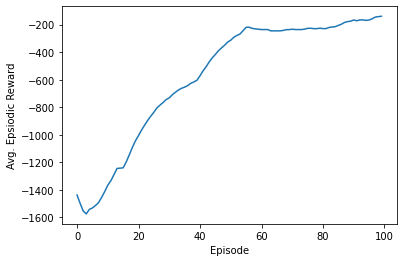

In [22]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        state, reward, done, info = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        # End this episode when `done` is True
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

If training proceeds correctly, the average episodic reward will increase with time.

Feel free to try different learning rates, `tau` values, and architectures for the
Actor and Critic networks.

The Inverted Pendulum problem has low complexity, but DDPG works well on many other
problems.

Another excellent environment to try this on is `LunarLandingContinuous-v2`, but it will take
more episodes to obtain good results.

In [23]:
# Save the weights
actor_model.save_weights("pendulum_actor.h5")
critic_model.save_weights("pendulum_critic.h5")

target_actor.save_weights("pendulum_target_actor.h5")
target_critic.save_weights("pendulum_target_critic.h5")

Before Training:

![before_img](https://i.imgur.com/ox6b9rC.gif)

After 100 episodes:

![after_img](https://i.imgur.com/eEH8Cz6.gif)

# Tensorflow Agents tutorial - RL on real world data with DDPG

A popular way to navigate Reinforcement Learning is through [Tensorflow Agents](https://github.com/tensorflow/agents). The example we will see next uses these agents to solve a problem of paying off mortgage and saving for retirement. Before you dive in, we recommend peeking at these tutorials on Tensorflow Agents: 

- [Hvaas-Labs RL tutorial](https://colab.research.google.com/github/Hvass-Labs/TensorFlow-Tutorials/blob/master/16_Reinforcement_Learning.ipynb#scrollTo=82khyceYqTGI)

- [Tensorflow Agents official tutorial](https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb)

- [Jeff Heaton's Deep Learning class module 12, tutorial 4](https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_04_atari.ipynb#scrollTo=jbY4yrjTEyc9)

The code below is also from a Jeff Heaton tutorial.



Creating an environment is the first step to applying TF-Agent-based reinforcement learning to a problem with your design.  In this part, we will see how to create your environment and apply it to an agent that allows actions to be floating-point values, rather than the discrete actions employed by the Deep Q-Networks (DQN) we used earlier. This new type of agent is called a Deep Deterministic Policy Gradients (DDPG) network. From an application standpoint, the primary difference between DDPG and DQN is that DQN only supports discrete actions, whereas DDPG supports continuous actions; however, there are other essential differences that we will cover later.

The environment that we will demonstrate simulates paying off a mortgage and saving for retirement. This simulation allows the agent to allocate their income between several types of account, buying luxury items, and paying off their mortgage. The goal is to maximize net worth.  Because we wish to provide the agent with the ability to distribute their income among several accounts, we provide continuous (floating point) actions that determine this distribution of the agent's salary.

We begin, similarly to previous TF-Agent examples, by importing needed packages.




In [25]:
! pip install pyvirtualdisplay
! pip install tf_agents
! sudo apt-get install xvfb

     |████████████████████████████████| 1.3 MB 14.3 MB/s 
     |████████████████████████████████| 18.3 MB 117 kB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,271 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 784 kB in 1s (1,215 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readlin

In [26]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import math
import numpy as np

import tensorflow as tf

from tf_agents.agents.ddpg import actor_network
from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.ddpg import ddpg_agent

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.trajectories import policy_step
from tf_agents.utils import common

import gym
from gym import spaces
from gym.utils import seeding
from gym.envs.registration import register
import PIL.ImageDraw
import PIL.Image
from PIL import ImageFont

Note, if you get the following error, restart and rerun the Google CoLab environment.  Sometimes a restart is needed after installing TF-Agents.

```
AttributeError: module 'google.protobuf.descriptor' has no 
    attribute '_internal_create_key'
```

We create a virtual display so that we can view the simulation in a Jupyter notebook.

In [27]:
# Set up a virtual display for rendering OpenAI gym environments.
vdisplay = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

### Create an Environment of your Own

An environment is a simulator that your agent runs in. An environment must have a current state. Some of this state is visible to the agent. However, the environment also hides some aspects of the state from the agent.  Likewise, the agent takes actions that will affect the state of the environment.  There may also be internal actions that occur outside the control of the agent.  For example, in the finance simulator demonstrated in this section, the agent does not control the investment returns or rate of inflation. Instead, the agent must react to these external actions and state components.

The environment class that you create must contain these elements:

* Be a child class of **gym.Env**
* Implement a **seed** function that sets a seed that governs the simulation's random aspects. For this environment, the seed oversees the random fluctuations in inflation and rates of return.
* Implement a **reset** function that resets the state for a new episode.
* Implement a **render** function that renders one frame of the simulation.  The rendering is only for display and does not affect reinforcement learning.
* Implement a **step** function that performs one step of your simulation.

The class presented below implements a financial planning simulation.  The agent must save for retirement and should attempt to amass the greatest possible net worth.  The simulation includes the following key elements:

* Random starting salary between 40K (USD) and 60K (USD).
* Home loan for a house with a random purchase price that is between 1.5 and 4 times the starting salary.
* Home loan is a standard amortized 30-year loan with a fixed monthly payment.
* Paying higher than the home's monthly payment pays the loan down quicker. Paying below the monthly payment results in late fees and eventually foreclosure.
* Ability to allocate income between luxury purchases, home payments (above or below payment amount), as well as a taxable and tax-advantaged savings account.

The state is composed of the following floating point values:

* **age** - The agent's current age in months (steps) 
* **salary** - The agent's starting salary, increases relative to inflation. 
* **home_value** - The value of the agent's home, increases relative to inflation.
* **home_loan** - How much the agent still owes on their home.
* **req_home_pmt** - The minimum required home payment.
* **acct_tax_adv** - The balance of the tax advantaged retirement account.
* **acct_tax**  - The balance of the taxable retuirement account.

The action space is composed of the following floating-point values (between 0 and 1):

* **home_loan** - The amount to apply to a home loan.
* **savings_tax_adv** - The amount to deposit in a tax-advantaged savings account.
* **savings taxable** - The amount to deposit in a taxable savings account.
* **luxury** - The amount to spend on luxury items/services.

The actions are weights that the program converts to a percentage of the total.  For example, the home loan percentage is the home loan action value divided by all actions (including a home loan).  The following code implements the environment and provides implementation details in the comments.

In [28]:
class SimpleGameOfLifeEnv(gym.Env):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 1
    }

    STATE_ELEMENTS = 7
    STATES = ['age', 'salary', 'home_value', 'home_loan', 'req_home_pmt', 
              'acct_tax_adv', 'acct_tax', "expenses", "actual_home_pmt", 
              "tax_deposit", 
              "tax_adv_deposit", "net_worth"]
    STATE_AGE = 0
    STATE_SALARY = 1
    STATE_HOME_VALUE = 2
    STATE_HOME_LOAN = 3
    STATE_HOME_REQ_PAYMENT = 4
    STATE_SAVE_TAX_ADV = 5
    STATE_SAVE_TAXABLE = 6

    MEG = 1.0e6

    ACTION_ELEMENTS = 4
    ACTION_HOME_LOAN = 0
    ACTION_SAVE_TAX_ADV = 1
    ACTION_SAVE_TAXABLE = 2
    ACTION_LUXURY = 3

    INFLATION = (0.015)/12.0
    INTEREST = (0.05)/12.0
    TAX_RATE = (.142)/12.0
    EXPENSES = 0.6
    INVEST_RETURN = 0.065/12.0
    SALARY_LOW = 40000.0
    SALARY_HIGH = 60000.0
    START_AGE = 18
    RETIRE_AGE = 80

    def __init__(self, goal_velocity=0):
      self.verbose = False
      self.viewer = None

      self.action_space = spaces.Box(
          low=0.0,
          high=1.0,
          shape=(SimpleGameOfLifeEnv.ACTION_ELEMENTS,),
          dtype=np.float32
      )
      self.observation_space = spaces.Box(
          low=0,
          high=2,
          shape=(SimpleGameOfLifeEnv.STATE_ELEMENTS,),
          dtype=np.float32
      )

      self.seed()
      self.reset()

      self.state_log = []

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _calc_net_worth(self):
      home_value = self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE]
      principal = self.state[SimpleGameOfLifeEnv.STATE_HOME_LOAN]
      worth = home_value - principal
      worth += self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAX_ADV]
      worth += self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE]
      return worth

    def _eval_action(self, action, payment):
      # Calculate actions
      act_home_payment = action[SimpleGameOfLifeEnv.ACTION_HOME_LOAN]
      act_tax_adv_pay = action[SimpleGameOfLifeEnv.ACTION_SAVE_TAX_ADV]
      act_taxable = action[SimpleGameOfLifeEnv.ACTION_SAVE_TAXABLE]
      act_luxury = action[SimpleGameOfLifeEnv.ACTION_LUXURY]
      if payment <=0:
        act_home_payment = 0
      total_act = act_home_payment + act_tax_adv_pay + act_taxable + \
            act_luxury + self.expenses

      if total_act <1e-2:
        pct_home_payment = 0
        pct_tax_adv_pay = 0
        pct_taxable = 0
        pct_luxury = 0
      else:
        pct_home_payment = act_home_payment / total_act
        pct_tax_adv_pay = act_tax_adv_pay / total_act
        pct_taxable = act_taxable / total_act
        pct_luxury = act_luxury / total_act

      return pct_home_payment, pct_tax_adv_pay, pct_taxable, pct_luxury

    def step(self, action):
      self.last_action = action
      age = self.state[SimpleGameOfLifeEnv.STATE_AGE]
      salary = self.state[SimpleGameOfLifeEnv.STATE_SALARY]
      home_value = self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE]
      principal = self.state[SimpleGameOfLifeEnv.STATE_HOME_LOAN]
      payment = self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT]
      net1 = self._calc_net_worth()
      remaining_salary = salary

      # Calculate actions
      pct_home_payment, pct_tax_adv_pay, pct_taxable, pct_luxury = \
        self._eval_action(action,payment)

      # Expenses
      current_expenses = salary * self.expenses
      remaining_salary -= current_expenses
      if self.verbose:
        print(f"Expenses: {current_expenses}")
        print(f"Remaining Salary: {remaining_salary}")

      # Tax advantaged deposit action
      my_tax_adv_deposit = min(salary * pct_tax_adv_pay, remaining_salary)
      my_tax_adv_deposit = min(my_tax_adv_deposit, \
        self.year_tax_adv_deposit_left) # Govt CAP
      self.year_tax_adv_deposit_left -= my_tax_adv_deposit
      remaining_salary -= my_tax_adv_deposit
      tax_adv_deposit = my_tax_adv_deposit * 1.05 # Company match
      self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAX_ADV] += \
        int(tax_adv_deposit)

      if self.verbose:
        print(f"IRA Deposit: {tax_adv_deposit}")
        print(f"Remaining Salary: {remaining_salary}")

      # Tax
      remaining_salary -= remaining_salary * SimpleGameOfLifeEnv.TAX_RATE
      if self.verbose:
        print(f"Tax Salary: {remaining_salary}")

      # Home payment
      actual_payment = min(salary * pct_home_payment, remaining_salary)

      if principal>0:
        ipart = principal * SimpleGameOfLifeEnv.INTEREST
        ppart = actual_payment - ipart
        principal = int(principal-ppart)
        if principal<=0:
          principal = 0
          self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT] = 0
        elif actual_payment < payment:
          self.late_count += 1
          if self.late_count>15:
            sell = (home_value-principal)/2
            sell -= 20000
            sell = max(sell,0)
            self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE] += sell
            principal = 0
            home_value = 0
            self.expenses += .3
            self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT] = 0
            if self.verbose:
              print(f"Foreclosure!!")
          else:
            late_fee = payment * 0.1
            principal += late_fee
            if self.verbose:
              print(f"Late Fee: {late_fee}")


        self.state[SimpleGameOfLifeEnv.STATE_HOME_LOAN] = principal
        remaining_salary -= actual_payment

      if self.verbose:
        print(f"Home Payment: {actual_payment}")
        print(f"Remaining Salary: {remaining_salary}")

      # Taxable savings
      actual_savings = remaining_salary * pct_taxable
      self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE] += actual_savings
      remaining_salary -= actual_savings

      if self.verbose:
        print(f"Tax Save: {actual_savings}")
        print(f"Remaining Salary (goes to Luxury): {remaining_salary}")

      # Investment income
      return_taxable = self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE] * \
          self.invest_return
      return_tax_adv = self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAX_ADV] * \
          self.invest_return

      return_taxable *= 1-SimpleGameOfLifeEnv.TAX_RATE
      self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE] += return_taxable
      self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAX_ADV] += return_tax_adv

      # Yearly events
      if age>0 and age % 12 == 0:
        self.perform_yearly()

      # Monthly events
      self.state[SimpleGameOfLifeEnv.STATE_AGE] += 1
      
      # Time to retire (by age?)
      done = self.state[SimpleGameOfLifeEnv.STATE_AGE] > \
        (SimpleGameOfLifeEnv.RETIRE_AGE*12)

      # Calculate reward 
      net2 = self._calc_net_worth()
      reward = net2 - net1

      # Track progress
      if self.verbose:
        print(f"Networth: {nw}")
        print(f"*** End Step {self.step_num}: State={self.state}, \
          Reward={reward}")
      self.state_log.append(self.state + [current_expenses, actual_payment, 
      actual_savings, my_tax_adv_deposit, net2])
      self.step_num += 1

      # Normalize state and finish up
      norm_state = [x/SimpleGameOfLifeEnv.MEG for x in self.state]
      return norm_state, reward/SimpleGameOfLifeEnv.MEG, done, {}

    def perform_yearly(self):
      salary = self.state[SimpleGameOfLifeEnv.STATE_SALARY]
      home_value = self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE]
      
      self.inflation = SimpleGameOfLifeEnv.INTEREST + \
          self.np_random.normal(loc=0,scale=1e-2)
      self.invest_return = SimpleGameOfLifeEnv.INVEST_RETURN + \
          self.np_random.normal(loc=0,scale=1e-2)

      self.year_tax_adv_deposit_left = 19000
      self.state[SimpleGameOfLifeEnv.STATE_SALARY] = \
        int(salary * (1+self.inflation))

      self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE] \
        = int(home_value * (1+self.inflation))

    def reset(self):
      self.expenses = SimpleGameOfLifeEnv.EXPENSES
      self.late_count = 0
      self.step_num = 0
      self.last_action = [0] * SimpleGameOfLifeEnv.ACTION_ELEMENTS
      self.state = [0] * SimpleGameOfLifeEnv.STATE_ELEMENTS
      self.state_log = []
      salary = float(self.np_random.randint(low=\
                SimpleGameOfLifeEnv.SALARY_LOW,\
                high=SimpleGameOfLifeEnv.SALARY_HIGH))
      house_mult = self.np_random.uniform(low=1.5,high=4)
      value = round(salary*house_mult)
      p = (value*0.9)
      i = SimpleGameOfLifeEnv.INTEREST
      n = 30 * 12
      m = float(int(p *  ( i * (1 + i)**n ) / ( (1 + i)**n - 1)))
      self.state[SimpleGameOfLifeEnv.STATE_AGE] = \
        SimpleGameOfLifeEnv.START_AGE * 12
      self.state[SimpleGameOfLifeEnv.STATE_SALARY] = salary / 12.0
      self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE] = value
      self.state[SimpleGameOfLifeEnv.STATE_HOME_LOAN] = p
      self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT] = m
      self.year_tax_adv_deposit_left = 19000
      self.perform_yearly()
      return np.array(self.state)

    def render(self, mode='human'):
        screen_width = 600
        screen_height = 400

        img = PIL.Image.new('RGB', (600, 400))
        d = PIL.ImageDraw.Draw(img)
        font = ImageFont.load_default()
        y = 0
        _, height = d.textsize("W", font)
  
        age = self.state[SimpleGameOfLifeEnv.STATE_AGE]
        salary = self.state[SimpleGameOfLifeEnv.STATE_SALARY]*12
        home_value = self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE]
        home_loan = self.state[SimpleGameOfLifeEnv.STATE_HOME_LOAN]
        home_payment = self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT]
        balance_tax_adv = self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAX_ADV]
        balance_taxable = self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE]
        net_worth = self._calc_net_worth()

        d.text((0, y), f"Age: {age/12}", fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Salary: {salary:,}", fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Home Value: {home_value:,}", \
                fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Home Loan: {home_loan:,}", \
               fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Home Payment: {home_payment:,}", \
               fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Balance Tax Adv: {balance_tax_adv:,}", \
               fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Balance Taxable: {balance_taxable:,}", \
               fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Net Worth: {net_worth:,}", fill=(0, 255, 0))
        y+=height*2

        payment = self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT]
        pct_home_payment, pct_tax_adv_pay, pct_taxable, pct_luxury = \
          self._eval_action(self.last_action,payment)
        d.text((0, y), f"Percent Home Payment: {pct_home_payment}", \
               fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Percent Tax Adv: {pct_tax_adv_pay}", 
               fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Percent Taxable: {pct_taxable}", fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Percent Luxury: {pct_luxury}", fill=(0, 255, 0))

        return np.array(img)

    def close(self):
        pass

You must register the environment class with TF-Agents before your program can use it.

In [29]:
register(
    id='simple-game-of-life-v0',
    entry_point=f'{__name__}:SimpleGameOfLifeEnv',
)

### Testing the Environment

This financial planning environment is complex.  It required some degree of testing to perfect it.  Even at the current state of this simulator, it is far from a complete financial simulator.  The primary objective of this simulator is to demonstrate creating your own environment for a non-video game project.

We used the following code to help test this simulator. We ran the simulator with fixed actions and then loaded the state into a Pandas data frame for easy viewing.

In [30]:
env_name = 'simple-game-of-life-v0'
env = gym.make(env_name)

env.reset()
done = False

i = 0
env.verbose = False
while not done:
    i += 1
    #if i>36: break
    # ACTION_HOME_LOAN = 0, ACTION_SAVE_TAX_ADV = 1, ACTION_SAVE_TAXABLE = 2
    # ACTION_LUXURY = 3
    state, reward, done, _ = env.step([1,1,0,0])
    env.render()
    
env.close()
print(env._calc_net_worth())

8950823.799884506


In [31]:
import pandas as pd

df = pd.DataFrame(env.state_log, columns=SimpleGameOfLifeEnv.STATES)
df = df.round(0)
df['age'] = df['age']/12
df['age'] = df['age'].round(2)
for col in df.columns:
  df[col] = df[col].apply(lambda x : "{:,}".format(x))

pd.set_option('display.max_columns', 7)
pd.set_option('display.max_rows', 12)
display(df)

,age,salary,home_value,...,tax_deposit,tax_adv_deposit,net_worth
0,18.08,"4,737","188,067",...,0.0,"1,843.0","15,040.0"
1,18.17,"4,737","188,067",...,0.0,"1,822.0","16,226.0"
2,18.25,"4,737","188,067",...,0.0,"1,822.0","17,419.0"
3,18.33,"4,737","188,067",...,0.0,"1,822.0","18,621.0"
4,18.42,"4,737","188,067",...,0.0,"1,822.0","19,832.0"
...,...,...,...,...,...,...,...
740,79.75,"5,790","231,109",...,0.0,579.0,"8,581,958.0"
741,79.83,"5,790","231,109",...,0.0,579.0,"8,672,511.0"
742,79.92,"5,790","231,109",...,0.0,579.0,"8,764,039.0"
743,80.0,"5,790","231,109",...,0.0,579.0,"8,856,553.0"


1810888.5833333335

## Hyperparameters

We tuned the following hyperparamaters to get a reasonable result from training the agent.  Further optimization would be beneficial.

In [32]:
# How long should training run?
num_iterations = 50000 
# How many initial random steps, before training start, to
# collect initial data.
initial_collect_steps = 1000   
# How many steps should we run each iteration to collect 
# data from.
collect_steps_per_iteration = 50
# How much data should we store for training examples.
replay_buffer_max_length = 100000

batch_size = 64  
#learning_rate = 1e-4 
# How often should the program provide an update.
log_interval = 2500  

# How many episodes should the program use for each evaluation.
num_eval_episodes = 100
# How often should an evaluation occur.
eval_interval = 5000  

## Instantiate the Environment

We are now ready to make use of our environment.  Because we registered the environment with TF-Agents the program can load the environment by its name "simple-game-of-life-v".  You can also try the continuous version of the mountain car environment by switching the name given below.  The continuous mountain car works similar to the discrete mountain car seen previously.  However, the continuous mountain car allows the degree of forward or backward force to be specified.

In [33]:
env_name = 'simple-game-of-life-v0'
#env_name = 'MountainCarContinuous-v0'
env = suite_gym.load(env_name)

We can now have a quick look at the first state rendered. Here we can see the random salary and home values are chosen for an agent.  The learned policy must be able to take into consideration different starting salaries and home values and find an appropriate strategy.

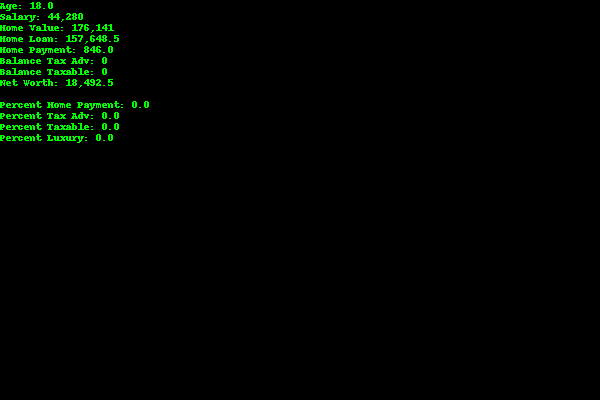

In [34]:
env.reset()
PIL.Image.fromarray(env.render())

As before, the program instantiates two environments: one for training and one for evaluation. 

In [35]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

Recall that DQN does not support continuous actions--the DQN algorithm maps each action as an output activation. Each of these activations predicts the likely future reward for taking each action. Generally, the DQN agent will perform the action with the highest reward. The algorithm knows the future rewards for each particular action.  However, because a continuous number represented in a computer has an effectively infinite number of possible values, it is not possible to calculate a future reward estimate for all of them.

To provide a continuous action space we will use the Deep Deterministic Policy Gradients (DDPG) algorithm. [[Cite:lillicrap2015continuous]](https://arxiv.org/abs/1509.02971) This technique uses two neural networks.  The first neural network, called an actor, acts as the agent and predicts the expected reward for a given value of the action.  The second neural network, called a critic, is trained to predict the accuracy of the actor-network.  Training two neural networks in parallel that operate adversarially to one another is a popular technique.  Earlier in this course, we saw that Generative Adversarial Networks (GAN) made use of a similar method. The figure below shows the structure of the DDPG network we will use. 

**DDPG: Actor Critic Model**
![Deep Q-Learning](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/actor-critic.png "Actor Critic Model")

The environment provides the same input ($x(t)$) for each time step to both the actor and critic networks. The temporal difference error ($r(t)$) reports the difference between the estimated reward at any given state or time step and the actual reward. 

The following code creates the actor and critic neural networks.

In [36]:
actor_fc_layers=(400, 300)
critic_obs_fc_layers=(400,)
critic_action_fc_layers=None
critic_joint_fc_layers=(300,)
ou_stddev=0.2
ou_damping=0.15
target_update_tau=0.05
target_update_period=5
dqda_clipping=None
td_errors_loss_fn=tf.compat.v1.losses.huber_loss
gamma=0.995
reward_scale_factor=1.0
gradient_clipping=None

actor_learning_rate=1e-4
critic_learning_rate=1e-3
debug_summaries=False
summarize_grads_and_vars=False

global_step = tf.compat.v1.train.get_or_create_global_step()

actor_net = actor_network.ActorNetwork(
        train_env.time_step_spec().observation,
        train_env.action_spec(),
        fc_layer_params=actor_fc_layers,
    )

critic_net_input_specs = (train_env.time_step_spec().observation,
                          train_env.action_spec())

critic_net = critic_network.CriticNetwork(
    critic_net_input_specs,
    observation_fc_layer_params=critic_obs_fc_layers,
    action_fc_layer_params=critic_action_fc_layers,
    joint_fc_layer_params=critic_joint_fc_layers,
)

tf_agent = ddpg_agent.DdpgAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=actor_learning_rate),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=critic_learning_rate),
    ou_stddev=ou_stddev,
    ou_damping=ou_damping,
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    dqda_clipping=dqda_clipping,
    td_errors_loss_fn=td_errors_loss_fn,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=gradient_clipping,
    debug_summaries=debug_summaries,
    summarize_grads_and_vars=summarize_grads_and_vars,
    train_step_counter=global_step)
tf_agent.initialize()



## Metrics and Evaluation

Just as in previous examples, we will compute the average return over several episodes to evaluate performance.


In [37]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of 
# different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

## Data Collection

Now execute the random policy in the environment for a few steps, recording the data in the replay buffer.

In [38]:
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

collect_data(train_env, random_policy, replay_buffer, steps=100)

# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


## Training the agent

We are now ready to train the agent. This process can take many hours, depending on how many episodes you wish to run through. As training occurs, this code will update on both the loss and average return. As training becomes more successful, the average return should increase. The losses reported reflecting the average loss for individual training batches.

In [39]:
iterator = iter(dataset)

# (Optional) Optimize by wrapping some of the code in a graph using 
# TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, \
                                num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, tf_agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = tf_agent.train(experience).loss

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, \
                                    num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

KeyboardInterrupt: ignored

## Visualization

The notebook can plot the average return over training iterations. The average return should increase as the program performs more training iterations.

### Plots

Use **matplotlib.pyplot** to chart how the policy improved during training.

One iteration of **Cartpole-v0** consists of 200 time steps. The environment gives a reward of `+1` for each step the pole stays up, so the maximum return for one episode is 200. The charts show the return increasing towards that maximum each time it is evaluated during training. (It may be a little unstable and not increase each time monotonically.)

In [ ]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=50)

### Videos

We use the following functions to produce video in Jupyter notebook.

In [41]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

create_policy_eval_video(tf_agent.policy, "trained-agent")

Output hidden; open in https://colab.research.google.com to view.

The agent's net worth is consistently rising!

# Reinforcement Learning for Finance



## Deep Reinforcement Learning for Stock Trading from Scratch: Portfolio Allocation

Tutorials to use OpenAI DRL to perform portfolio allocation | Drawn from a Presentation at NeurIPS 2020: Deep RL Workshop

* This blog is based on the paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: 
* Please report any issues to the Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



### Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


### Part 2. Getting Started- Load Python Packages

### 2.1. Install all the packages through FinRL library


In [1]:
## install finrl library
!pip install -U finrl

     |████████████████████████████████| 133 kB 4.3 MB/s 
     |████████████████████████████████| 91 kB 9.2 MB/s 
     |████████████████████████████████| 2.6 MB 56.4 MB/s 
     |████████████████████████████████| 53.2 MB 1.2 MB/s 
     |████████████████████████████████| 197 kB 81.3 MB/s 
     |████████████████████████████████| 1.2 MB 46.0 MB/s 
     |████████████████████████████████| 234 kB 77.8 MB/s 
     |████████████████████████████████| 153 kB 77.6 MB/s 
     |████████████████████████████████| 125 kB 64.7 MB/s 
     |████████████████████████████████| 177 kB 71.9 MB/s 
     |████████████████████████████████| 150 kB 81.0 MB/s 
     |████████████████████████████████| 271 kB 74.8 MB/s 
     |████████████████████████████████| 1.1 MB 61.3 MB/s 
     |████████████████████████████████| 1.1 MB 55.9 MB/s 
     |████████████████████████████████| 4.0 MB 56.6 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
     |████████████████████████████████| 291 kB 78.8 MB/s 
     |█████████████

In [3]:
#restart the kernel after running this block.
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}

!pip install yfinance
!pip install pandas
!pip install matplotlib
!pip install stockstats
!pip install gym
!pip install stable-baselines[mpi]
!pip install tensorflow==1.15.4


  Using cached stable_baselines-2.10.2-py3-none-any.whl (240 kB)
  Using cached mpi4py-3.1.3.tar.gz (2.5 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185284 sha256=3f02e19d01bd64bb7d41c581f84a6dd26a708bf528a3669bda23f40c529ee5b9
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successfully built mpi4py
     |████████████████████████████████| 110.5 MB 120.2 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
     |████████████████████████████████| 20.1 MB 962 kB/s 
     |████████████████████████████████| 503 kB 37.3 MB/s 
     |████████████████████████████████| 3.8 MB 52.1 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=c02ecf1d7b1462583f7085da5089e33dc4da6746e03d60374088c9427776aae4
  Stored in directory: /root/.cac


### 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

### 2.3. Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_portfolio import StockPortfolioEnv

from finrl.model.models import DRLAgent
# from finrl.trade.backtest import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts

import sys
sys.path.append("../FinRL-Library")

### 2.4. Create Folders

In [2]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

### Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).


In [3]:
print(config.DOW_30_TICKER)

['AAPL', 'MSFT', 'JPM', 'V', 'RTX', 'PG', 'GS', 'NKE', 'DIS', 'AXP', 'HD', 'INTC', 'WMT', 'IBM', 'MRK', 'UNH', 'KO', 'CAT', 'TRV', 'JNJ', 'CVX', 'MCD', 'VZ', 'CSCO', 'XOM', 'BA', 'MMM', 'PFE', 'WBA', 'DD']


In [4]:
df = YahooDownloader(start_date = '2008-01-01',
                     end_date = '2021-01-01',
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

/usr/local/lib/python3.7/dist-packages/finrl/marketdata/yahoodownloader.py:69: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_df = data_df.drop("adjcp", 1)


Shape of DataFrame:  (98167, 8)


In [5]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2008-01-02,7.116786,7.152143,6.876786,5.958446,1079178800,AAPL,2
1,2008-01-02,52.090000,52.320000,50.790001,40.477768,8053700,AXP,2
2,2008-01-02,87.570000,87.839996,86.000000,63.481613,4303000,BA,2
3,2008-01-02,72.559998,72.669998,70.050003,47.176800,6337800,CAT,2
4,2008-01-02,27.000000,27.299999,26.209999,19.193113,64338900,CSCO,2


In [6]:
df.shape

(98167, 8)

### Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [7]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

df = fe.preprocess_data(df)

Successfully added technical indicators


In [8]:
df.shape

(98167, 16)

In [9]:
df.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2008-01-02,7.116786,7.152143,6.876786,5.958446,1079178800,AAPL,2,0.000000,5.963713,5.955930,100.000000,-66.666667,100.0,5.958446,5.958446
1,2008-01-02,52.090000,52.320000,50.790001,40.477768,8053700,AXP,2,0.000062,5.963713,5.955930,100.000000,-66.666667,100.0,5.959821,5.959821
2,2008-01-02,87.570000,87.839996,86.000000,63.481613,4303000,BA,2,-0.014032,6.332461,5.284733,0.581177,-100.000000,100.0,5.808597,5.808597
3,2008-01-02,72.559998,72.669998,70.050003,47.176800,6337800,CAT,2,-0.022760,6.284159,5.144961,0.498192,-98.367616,100.0,5.714560,5.714560
4,2008-01-02,27.000000,27.299999,26.209999,19.193113,64338900,CSCO,2,-0.034799,6.271556,4.966554,0.357986,-86.822816,100.0,5.619055,5.619055


#### Add covariance matrix as states

In [10]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  covs = return_lookback.cov().values 
  cov_list.append(covs)
  
df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)
        

In [11]:
df.shape

(90660, 17)

In [12]:
df.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list
0,2008-12-31,3.070357,3.133571,3.047857,2.610106,607541200,AAPL,2,0.112284,53.286010,47.561928,48.009264,25.841097,5.858025,50.614906,50.970385,"[[0.0014139100106232375, 0.0011800737903184346..."
1,2008-12-31,17.969999,18.750000,17.910000,14.908461,9625600,AXP,2,0.225514,53.469343,47.791637,51.045376,80.049007,0.220406,50.690793,50.894581,"[[0.0014139100106232375, 0.0011800737903184346..."
2,2008-12-31,41.590000,43.049999,41.500000,32.005890,5443100,BA,2,0.322032,53.717287,47.766476,51.269636,96.444484,2.969231,50.754755,50.823502,"[[0.0014139100106232375, 0.0011800737903184346..."
3,2008-12-31,43.700001,45.099998,43.700001,30.628830,6277400,CAT,2,0.327177,53.791300,47.768895,49.751677,71.687267,0.296878,50.778334,50.740349,"[[0.0014139100106232375, 0.0011800737903184346..."
4,2008-12-31,16.180000,16.549999,16.120001,11.787783,37513700,CSCO,2,0.511683,54.318893,47.618567,53.664770,172.385044,17.964888,50.874006,50.731082,"[[0.0014139100106232375, 0.0011800737903184346..."


### Part 5. Design the Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

### Training data split: 2009-01-01 to 2018-12-31

In [13]:
train = data_split(df, '2009-01-01','2019-01-01')
#trade = data_split(df, '2020-01-01', config.END_DATE)

In [14]:
train.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list
0,2009-01-02,3.067143,3.251429,3.041429,2.775245,746015200,AAPL,4,0.916408,58.037312,50.483559,58.279405,231.362655,28.830569,53.921121,52.268014,"[[0.0014277082780051412, 0.0011886545510691592..."
0,2009-01-02,18.570000,19.520000,18.400000,15.535345,10955700,AXP,4,1.104876,58.632919,50.354921,57.951212,206.221387,31.974391,54.109571,52.400182,"[[0.0014277082780051412, 0.0011886545510691592..."
0,2009-01-02,42.799999,45.560001,42.779999,33.941093,7010200,BA,4,1.225587,59.109107,50.287863,57.599736,171.846935,31.974391,54.287686,52.521220,"[[0.0014277082780051412, 0.0011886545510691592..."
0,2009-01-02,44.910000,46.980000,44.709999,32.164722,7117200,CAT,4,1.288570,59.477773,50.242410,57.159556,138.088238,22.759063,54.486351,52.632342,"[[0.0014277082780051412, 0.0011886545510691592..."
0,2009-01-02,16.410000,17.000000,16.250000,12.265082,40980600,CSCO,4,1.295163,59.737544,50.442498,56.448857,117.946012,22.759063,54.596317,52.735161,"[[0.0014277082780051412, 0.0011886545510691592..."


### Environment for Portfolio Allocation


In [15]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value 
            #print("Step reward: ", self.reward)
            #self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [16]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 30, State Space: 30


In [17]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

In [18]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


### Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [19]:
# initialize
agent = DRLAgent(env = env_train)

### Model 1: **A2C** (Actor Critic)


In [20]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [21]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=60000)

Logging to tensorboard_log/a2c/a2c_1
------------------------------------
| time/                 |          |
|    fps                | 174      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -42.5    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 99       |
|    policy_loss        | 2.03e+08 |
|    std                | 0.997    |
|    value_loss         | 2.48e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 224      |
|    iterations         | 200      |
|    time_elapsed       | 4        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -42.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 199      |
|

### Model 2: **PPO** (Proximal Policy Optimization)


In [22]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cpu device


In [23]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=80000)

Logging to tensorboard_log/ppo/ppo_1
-----------------------------
| time/              |      |
|    fps             | 430  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
begin_total_asset:1000000
end_total_asset:4693911.617073888
Sharpe:  1.0449456411900337
--------------------------------------
| time/                   |          |
|    fps                  | 382      |
|    iterations           | 2        |
|    time_elapsed         | 10       |
|    total_timesteps      | 4096     |
| train/                  |          |
|    approx_kl            | 0.0      |
|    clip_fraction        | 0        |
|    clip_range           | 0.2      |
|    entropy_loss         | -42.6    |
|    explained_variance   | 0        |
|    learning_rate        | 0.0001   |
|    loss                 | 7.65e+14 |
|    n_updates            | 10       |
|    policy_gradient_loss | -5e-07   |
|    std                  | 1        |
| 

### Model 3: **DDPG** (Deep Deterministic Policy Gradients)


In [24]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}


model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [25]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

Logging to tensorboard_log/ddpg/ddpg_1
begin_total_asset:1000000
end_total_asset:4637487.096051112
Sharpe:  1.0327553915353764
begin_total_asset:1000000
end_total_asset:4522294.923808918
Sharpe:  1.056520737385653
begin_total_asset:1000000
end_total_asset:4522294.923808918
Sharpe:  1.056520737385653
begin_total_asset:1000000
end_total_asset:4522294.923808918
Sharpe:  1.056520737385653
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 49        |
|    time_elapsed    | 204       |
|    total_timesteps | 10064     |
| train/             |           |
|    actor_loss      | -6.61e+07 |
|    critic_loss     | 1.93e+13  |
|    learning_rate   | 0.001     |
|    n_updates       | 7548      |
----------------------------------
begin_total_asset:1000000
end_total_asset:4522294.923808918
Sharpe:  1.056520737385653
begin_total_asset:1000000
end_total_asset:4522294.923808918
Sharpe:  1.056520737385653
begin_total_asset:

### Model 4: **SAC** (Soft Actor Critic)

Soft Actor Critic (SAC) is an algorithm that optimizes a stochastic policy in an off-policy way, forming a bridge between stochastic policy optimization and DDPG-style approaches. It incorporates the clipped double-Q trick, and due to the inherent stochasticity of the policy in SAC, it benefits from target policy smoothing.

A central feature of SAC is entropy regularization. The policy is trained to maximize a trade-off between expected return and entropy, a measure of randomness in the policy. This has a close connection to the exploration-exploitation trade-off: increasing entropy results in more exploration, which can accelerate learning later on. It can also prevent the policy from prematurely converging to a bad local optimum.


In [26]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


In [27]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=50000)

Logging to tensorboard_log/sac/sac_1
begin_total_asset:1000000
end_total_asset:4690616.743585024
Sharpe:  1.068653893929399
begin_total_asset:1000000
end_total_asset:4523758.263730788
Sharpe:  1.055628504530759
begin_total_asset:1000000
end_total_asset:4523755.111236704
Sharpe:  1.05562822200797
begin_total_asset:1000000
end_total_asset:4523753.046577074
Sharpe:  1.0556281240347065
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 34        |
|    time_elapsed    | 290       |
|    total_timesteps | 10064     |
| train/             |           |
|    actor_loss      | -8.22e+07 |
|    critic_loss     | 3.18e+13  |
|    ent_coef        | 2.33      |
|    ent_coef_loss   | -239      |
|    learning_rate   | 0.0003    |
|    n_updates       | 9963      |
----------------------------------
begin_total_asset:1000000
end_total_asset:4523753.046577074
Sharpe:  1.0556281240347065
begin_total_asset:1000000
end_total_a

### Trading
Assume that we have $1,000,000 initial capital at 2019-01-01. We use the DDPG model to trade Dow jones 30 stocks.

In [28]:
trade = data_split(df,'2019-01-01', '2021-01-01')
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)


In [29]:
trade.shape

(15150, 17)

In [30]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

begin_total_asset:1000000
end_total_asset:1389028.9302316473
Sharpe:  0.7396188290160893
hit end!


In [31]:
df_daily_return.head()

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.026016
2,2019-01-04,0.031910
3,2019-01-07,0.003951
4,2019-01-08,0.009409


In [32]:
df_actions.head()

,AAPL,AXP,BA,CAT,CSCO,CVX,DD,DIS,GS,HD,...,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
2019-01-03,0.058167,0.021398,0.021764,0.048239,0.021398,0.058167,0.021398,0.021398,0.038364,0.045761,...,0.021398,0.028547,0.021398,0.021398,0.028699,0.028470,0.058167,0.021398,0.021398,0.021398
2019-01-04,0.017181,0.043305,0.043178,0.017181,0.017181,0.046702,0.046702,0.042161,0.046702,0.017181,...,0.017181,0.024537,0.046702,0.046702,0.017181,0.046702,0.046702,0.046702,0.046702,0.035099
2019-01-07,0.060639,0.022308,0.058616,0.022308,0.022308,0.053711,0.022308,0.022308,0.022308,0.040096,...,0.060639,0.041304,0.022308,0.022308,0.022308,0.022308,0.060639,0.022308,0.022308,0.051915
2019-01-08,0.059519,0.031454,0.021896,0.036060,0.059519,0.021896,0.030097,0.021896,0.059519,0.024551,...,0.021896,0.021896,0.037538,0.021896,0.053625,0.029183,0.021896,0.023527,0.021896,0.059519


In [33]:
df_actions.to_csv('df_actions.csv')

### Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

## Now let's ensemble over Reinforcement Learned agents!

## Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using an Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy | Based on a version resented at ICAIF 2020

* This notebook is the reimplementation of the paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



### Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


### Part 2. Getting Started- Load Python Packages

### 2.1. Install all the packages through FinRL library


In [ ]:
# ## install finrl library
# !pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git


### 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

### 2.3. Import Packages

In [35]:
import warnings
warnings.filterwarnings("ignore")

In [37]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading import StockTradingEnv
from finrl.model.models import DRLAgent,DRLEnsembleAgent
# from finrl.trade.backtest import BackTestStats, BaselineStats, BackTestPlot

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

### 2.4. Create Folders

In [38]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

### Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [39]:
# from config.py start_date is a string
config.START_DATE

'2000-01-01'

In [40]:
print(config.SRI_KEHATI_TICKER)

['AALI.JK', 'ADHI.JK', 'ASII.JK', 'BBCA.JK', 'BBNI.JK', 'BBRI.JK', 'BBTN.JK', 'BMRI.JK', 'BSDE.JK', 'INDF.JK', 'JPFA.JK', 'JSMR.JK', 'KLBF.JK', 'PGAS.JK', 'PJAA.JK', 'PPRO.JK', 'SIDO.JK', 'SMGR.JK', 'TINS.JK', 'TLKM.JK', 'UNTR.JK', 'UNVR.JK', 'WIKA.JK', 'WSKT.JK', 'WTON.JK']


In [41]:
df = YahooDownloader(start_date = config.START_DATE,
                     end_date = '2021-01-19',
                     ticker_list = config.SRI_KEHATI_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [42]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2000-09-05,455.352478,455.352478,441.553925,249.921371,3712343.0,UNTR.JK,1
1,2000-09-06,441.553925,464.551514,436.954376,252.471680,6793100.0,UNTR.JK,2
2,2000-09-07,450.752960,459.951996,446.153442,252.471680,5011392.0,UNTR.JK,3
3,2000-09-08,450.752960,455.352478,446.153442,249.921371,2277955.0,UNTR.JK,4
4,2000-09-11,441.553925,441.553925,427.755341,239.720566,978362.0,UNTR.JK,0


In [43]:
df.tail()

,date,open,high,low,close,volume,tic,day
95413,2021-01-18,26300.0,26850.0,25950.0,25012.246094,4282500.0,UNTR.JK,0
95414,2021-01-18,6950.0,7525.0,6900.0,7261.655762,44943900.0,UNVR.JK,0
95415,2021-01-18,2410.0,2450.0,2220.0,2250.000000,234257600.0,WIKA.JK,0
95416,2021-01-18,1960.0,2080.0,1905.0,1920.000000,727533400.0,WSKT.JK,0
95417,2021-01-18,430.0,525.0,430.0,441.445801,418011900.0,WTON.JK,0


In [44]:
df.shape

(95418, 8)

In [45]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2000-09-05,455.352478,455.352478,441.553925,249.921371,3712343.0,UNTR.JK,1
1,2000-09-06,441.553925,464.551514,436.954376,252.471680,6793100.0,UNTR.JK,2
2,2000-09-07,450.752960,459.951996,446.153442,252.471680,5011392.0,UNTR.JK,3
3,2000-09-08,450.752960,455.352478,446.153442,249.921371,2277955.0,UNTR.JK,4
4,2000-09-11,441.553925,441.553925,427.755341,239.720566,978362.0,UNTR.JK,0


### Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [46]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [47]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [48]:
processed_full.sample(5)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
2652,2000-12-20,ASII.JK,156.493439,160.357468,156.493439,86.115128,74494658.0,2.0,-6.388314,169.018972,128.336480,36.258109,-57.858829,26.656233,157.008448,182.510641,0.000000
135951,2015-07-27,INDF.JK,6075.000000,6100.000000,5975.000000,4875.154297,4689900.0,0.0,17.230692,586.181160,514.530101,60.087186,76.143222,24.911368,532.723528,496.875892,51.788713
115750,2013-05-10,UNTR.JK,17250.000000,17450.000000,17050.000000,11713.349609,4754500.0,4.0,81.060380,1832.036405,1559.841122,67.728202,98.386789,34.746956,1614.393433,1433.158978,9.360066
178063,2020-03-06,BBCA.JK,6350.000000,6350.000000,6200.000000,5882.049316,77835500.0,4.0,-34.509436,1669.971531,1455.455337,45.549677,-9.855733,12.291197,1614.215055,1709.007890,54.842110
112416,2012-12-27,SMGR.JK,15700.000000,15950.000000,15700.000000,12531.427734,3249500.0,3.0,-8.837877,1374.157602,1324.075100,44.504408,-109.199855,8.417592,1358.402783,1372.789132,21.774045


### 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], because the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [49]:
config.TECHNICAL_INDICATORS_LIST

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [50]:
stock_dimension = len(processed_full.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 25, State Space: 251


In [51]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 50_000_000/100, #Since in Indonesia the minimum number of shares per trx is 100, then we scaled the initial amount by dividing it with 100 
    "buy_cost_pct": 0.0019, #IPOT has 0.19% buy cost
    "sell_cost_pct": 0.0029, #IPOT has 0.29% sell cost
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

### 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3 (we've seen all of these but Multi-Agent DDPG). We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [52]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)
train_start = '2000-01-01'
train_end = '2019-01-01'
val_test_start = '2019-01-01'
val_test_end = '2021-01-18'

ensemble_agent = DRLEnsembleAgent(df=processed_full,
                 train_period=(train_start,train_end),
                 val_test_period=(val_test_start,val_test_end),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)

In [53]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.01,
                    'learning_rate': 0.0005
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      "action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 50_000,
                      "learning_rate": 0.000005,
                      "batch_size": 128
                    }

timesteps_dict = {'a2c' : 100_000, 
                 'ppo' : 100_000, 
                 'ddpg' : 50_000
                 }

In [ ]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

In [ ]:
df_summary

# Advanced Reinforcement Learning Material

This section contains links to advanced and nonstandard RL material that go beyond those described above. 

## Multi-Agent Reinforcement Learning (MARL)

Many problems involve more than one player/agent (e.g., a basketball team) and it is likely that you can improve performance if you systematically model the problem with multiple agents in mind.

MARL addresses the sequential decision-making problem of multiple autonomous agents operating in a common environment. Each attempts to optimize retruns by interacting with *both* the environment and other agents.

MARL approaches tend to be cooperative, competitive, or a mixture of both. In cooperative MARL, agents collaborate to optimize a long-term shared goal. In competitive MARL, the reward sums to zerio, common in domains like price bidding and trading. Mixed MARL might include a social media platform seeking to use ads to both maximize global revenue while also maintaining user-engagement.

MARL faces several challenges:

1) there are more things to consider (and more potential solutions to any problem);

2) the goal of one agent may be different enough from another that it can be challenging to share policies

3) sharing information between agents imposes communication costs, which decrease model efficiency

4) the environment is nonstationary from the perspective of one agent if acted upon by another agent, which breaks some of the basic assumptions of MDP and can lead to a lack of stability.

5) its is hard to define optimality for real-world examples and so there is no convergence guarantees for nontrivial environments.

With those caveats, here are a few repositories with working code:

https://github.com/koulanurag/marl-pytorch


Multi-agent DDPG:

https://github.com/starry-sky6688/MADDPG

Multi-agent PPO:

https://pythonrepo.com/repo/marlbenchmark-on-policy

## Inverse Reinforcement Learning

This approach takes an agent's actions and environment to infer the rewards to which they are responding. The following paper tries to infer the rewards to physicians ordering tests, but there are many institutions and individuals whose actions and environment can be inverted to reveal the rewards to which they are responding. 

[LEARNING "WHAT-IF" EXPLANATIONS
FOR SEQUENTIAL DECISION-MAKING](https://arxiv.org/pdf/2007.13531.pdf)

## Reinforcement Learning for Text

[Microsoft TextWorld](https://github.com/microsoft/TextWorld)

## Distributional Reinforcement Learning

[A Distributional Perspective on Reinforcement Learning](http://proceedings.mlr.press/v70/bellemare17a/bellemare17a.pdf)

[A distributional code for value in dopamine-based reinforcement learning
](https://www.nature.com/articles/s41586-019-1924-6)

## Reinforcement Learning for Neuroscience and Social Robots

[Deep Reinforcement Learning and
its Neuroscientific Implications](https://arxiv.org/pdf/2007.03750.pdf)

[Social robot learning with deep
reinforcement learning and realistic
reward shaping](https://uu.diva-portal.org/smash/get/diva2:1365641/FULLTEXT01.pdf)

# Homework

In the last homework, we brainstormed how we would include RL in a social scientific context, ideally related to our final project. In this homework, you can either:

**a)** Use any Deep RL based method on any social scientific context or dataset, ideally related to your final project.

**b)** Use a Deep RL method on one of the environments shared with the OpenAI gym beyond those directly implemented here.